# Try to add a nifty model for sampling the input map

downloaded data (4.0 MB) to /tmp/maria-data/maps/cluster.fits


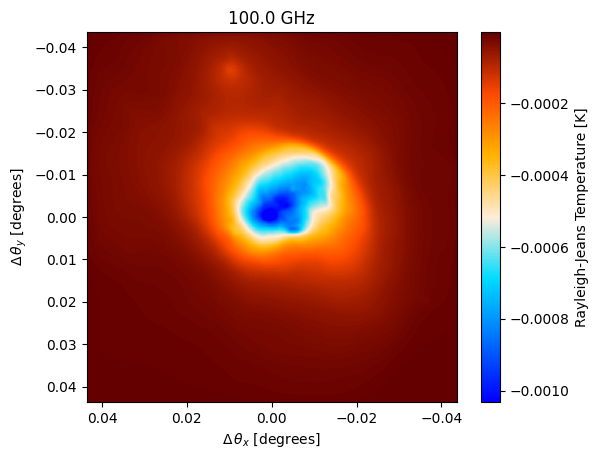

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import maria

import jax.numpy as jnp

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

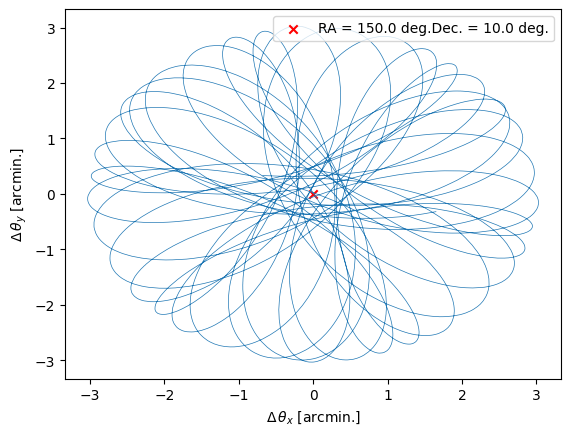

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

In [3]:
instrument = maria.get_instrument('MUSTANG-2')
# instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                # atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

2024-09-19 14:31:59.548 INFO: Constructed instrument.
2024-09-19 14:31:59.549 INFO: Constructed plan.
2024-09-19 14:31:59.550 INFO: Constructed site.
2024-09-19 14:32:00.148 INFO: Constructed boresight.
2024-09-19 14:32:00.564 INFO: Constructed offsets.


Initialized base in 1016 ms.


Sampling map (m2/f093): 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


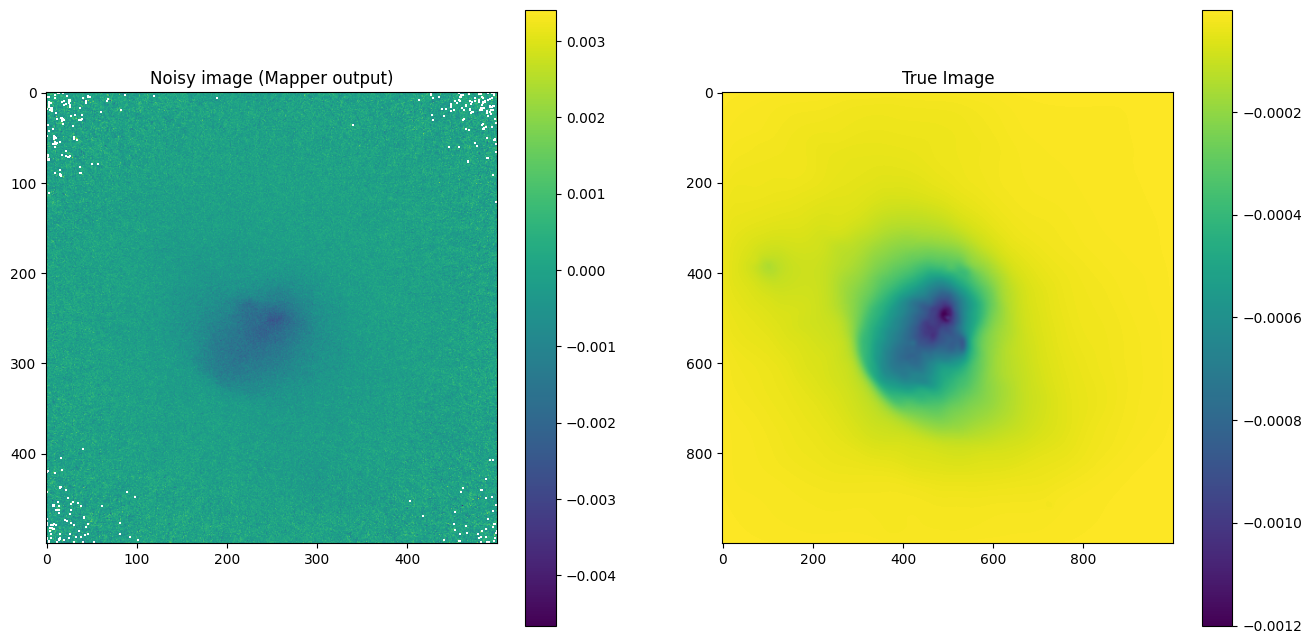

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

import jax
import nifty8.re as jft
import matplotlib.pyplot as plt

from jax import random

seed = 42
key = random.PRNGKey(seed)

2024-09-19 14:32:13.692 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-09-19 14:32:13.694 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [7]:
# jax compatible rewrite if beams.separably_filter
@jax.jit
def separably_filter(data, F, tol=1e-2, return_filter=False):
    """
    This is more efficient than 2d convolution
    """

    assert data.ndim == 2

    u, s, v = jax.numpy.linalg.svd(F)
    effective_filter = 0
    filtered_image = 0

    # pad data array to achieve mirroring effect
    data = jax.numpy.column_stack([data[:,0], data, data[:, -1]]) # axis=1
    data = jax.numpy.vstack([data[0], data, data[-1]]) # axis=0

    for m in range(len(F)):
        effective_filter += s[m] * u[:, m : m + 1] @ v[m : m + 1]
        
        # Turn kernels into shape (1, dim) to work in nd function
        u_kernel = jax.numpy.broadcast_to(u[:, m], (1, u[:, m].size))
        v_kernel = jax.numpy.broadcast_to(u[:, m], (1, v[m].size))
        
        filtered_image += s[m] * jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')[1:-1, 1:-1]

    return (filtered_image, effective_filter) if return_filter else filtered_image

In [8]:
@jax.jit
def construct_beam_filter(fwhm, res, buffer=1):
    """
    Make a beam filter for an image.
    """

    # if beam_profile is None:
    #     # beam_profile = lambda r, r0: np.where(r <= r0, 1., 0.)

    #     # a top hat
    #     def beam_profile(r, r0):
    #         return np.exp(-((r / r0) ** 16))

    filter_width = buffer * fwhm

    # n_side = jax.numpy.maximum(filter_width / res, 3).astype(int) # n_side = 3

    filter_side = jax.numpy.linspace(-filter_width / 2, filter_width / 2, 3)
    X, Y = jax.numpy.meshgrid(filter_side, filter_side, indexing="ij")
    R = jax.numpy.sqrt(jax.numpy.square(X) + jax.numpy.square(Y))
    F = jax.numpy.exp(-((R / (fwhm / 2)) ** 16))

    return F / F.sum()

In [9]:
from maria.constants import k_B
from maria.instrument import beams

@jax.jit
def sample_maps(sim_truthmap, dx, dy, resolution, x_side, y_side):

    data_map = jax.numpy.array(1e-16 * np.random.standard_normal(size=dx.shape))
    pbar = instrument.bands

    for band in pbar:
        band_mask = instrument.dets.band_name == band.name

        nu = jax.numpy.linspace(band.nu_min, band.nu_max, 64)
        TRJ = jax.scipy.interpolate.RegularGridInterpolator(
            (jax.numpy.array([100.]),),
            sim_truthmap,
            fill_value=None,
            bounds_error=False,
            method='nearest',
        )(nu)


        nu_passband = jax.numpy.exp(jax.numpy.log(0.5) * (2 * (nu - 90.) / 30.) ** 2)
        power_map = (
            1e12
            * k_B
            * jax.numpy.trapezoid(nu_passband[:, None, None] * TRJ, axis=0, x=1e9 * nu)
        )

        # nu is in GHz, f is in Hz
        nu_fwhm = beams.compute_angular_fwhm(
            # fwhm_0=sim_truthmap.instrument.dets.primary_size.mean(),
            fwhm_0=instrument.dets.primary_size.mean(),
            z=np.inf,
            f=1e9 * band.center,
        ) 
        
        nu_map_filter = construct_beam_filter(fwhm=nu_fwhm, res=resolution)
        filtered_power_map = separably_filter(power_map, nu_map_filter)
        
        # jax:
        map_power = jax.scipy.interpolate.RegularGridInterpolator(
            # Need to invert x_side and y_side for jax interpolation:
            (jax.numpy.flip(x_side), jax.numpy.flip(y_side)), # length N=2 sequence of arrays with grid coords
            # jax.numpy.flip(sim_truthmap[0]),
            jax.numpy.flip(filtered_power_map), # N=2-dimensional array specifying grid values (1000, 1000)
            fill_value=0.,
            bounds_error=False,
            method="linear",
        )((jax.numpy.array(dx[band_mask]), jax.numpy.array(dy[band_mask])))

        # jax.debug.print("Total map power: {pwr}", pwr=map_power.sum())

        # data["map"][band_mask] += map_power
        data_map = data_map.at[band_mask].add(map_power)
        
    # return sim_truthmap.data["map"]
    return data_map

## Test TOD agreement for noise-free map

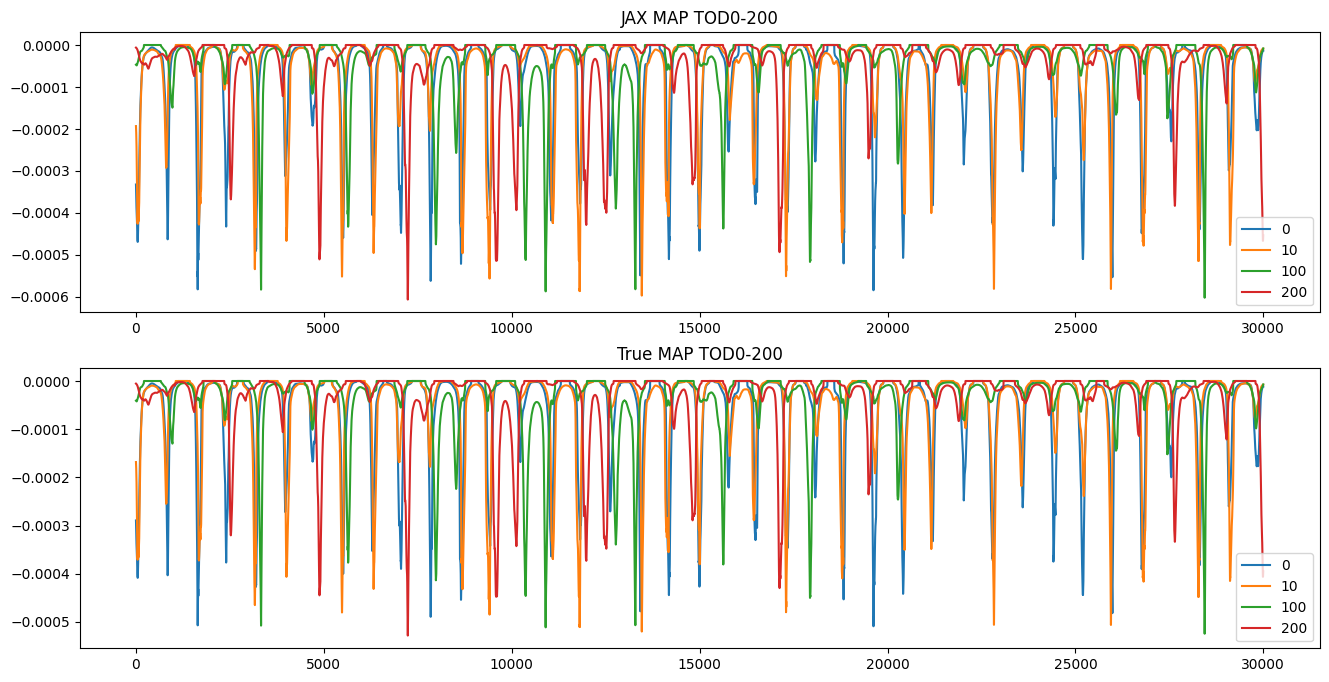

In [10]:
jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    tods_map = np.float64(tod_truthmap.components['map'].compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

# Next, initialise nifty prior model

Noise stddev: 0.00025168262


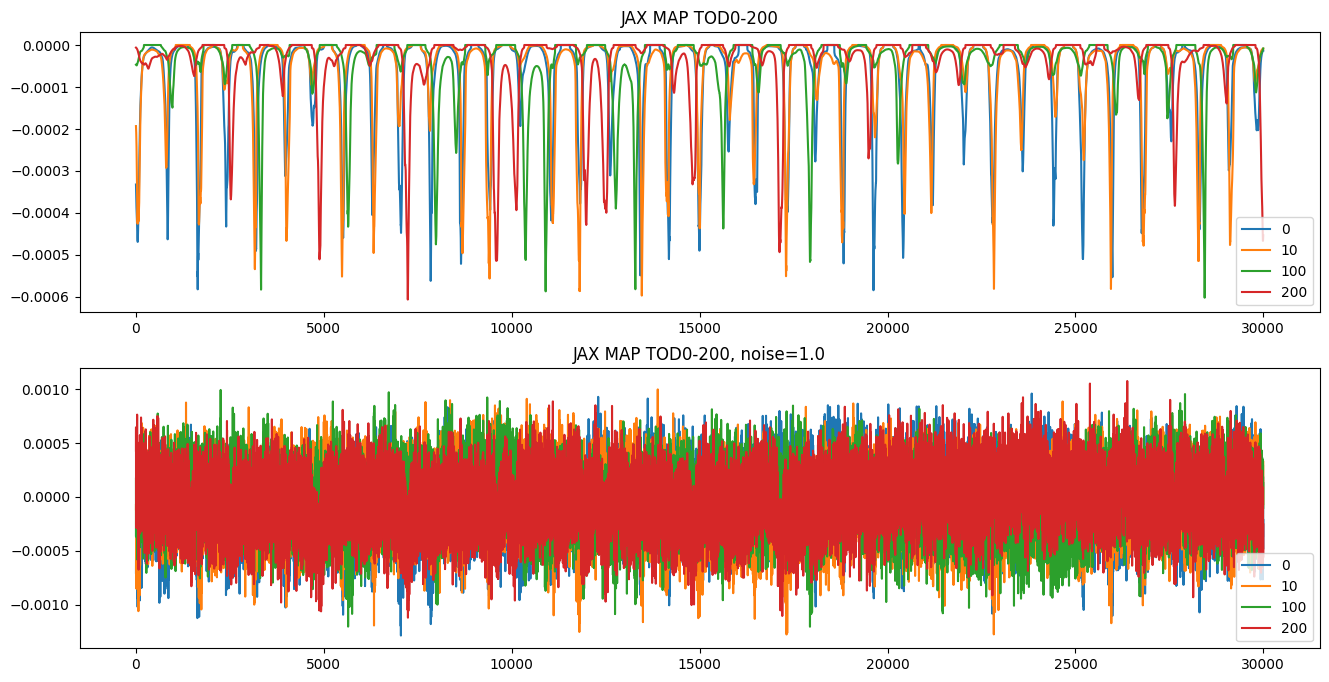

In [11]:
# Pick noise level for rest of run:
# noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
noiselevel = 1.0

jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
noised_jax_tod = jax_tods + np.float64(tod_truthmap.components['noise']*noiselevel)

print("Noise stddev:", np.std(tod_truthmap.components['noise'].compute()))

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    im1 = axes[1].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'JAX MAP TOD0-{i}, noise={noiselevel}')
axes[1].legend()

plt.show()

In [12]:
# dims = (128, 128)
dims = (1000, 1000)
# dims = (500, 500)

# Map model

# correlated field zero mode GP offset and stddev
cf_zm_map = dict(offset_mean=-8.7e-5, offset_std=(5e-6, 5e-6))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    fluctuations=(1e-3, 1e-4), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-3e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims, distances=1.0 / dims[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [13]:
# Define simple signal model with added map sampling
class Signal_TOD(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        return sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims[0], dims[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

class Signal_map(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        return self.gp_map(x)
  
signal_response_tod = Signal_TOD(gp_map)
signal_response_map = Signal_map(gp_map)

# Define noise covariance
noise_cov_inv_map = lambda x: 1e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
# elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 5e-6**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood
tods_map = np.float64(tod_truthmap.data.compute())
# lh_tod = jft.Gaussian( jax_tods, noise_cov_inv_tod).amend(signal_response_tod)
lh_tod = jft.Gaussian( noised_jax_tod, noise_cov_inv_tod).amend(signal_response_tod)
lh_map = jft.Gaussian( mapdata_truth[0], noise_cov_inv_map).amend(signal_response_map) # true map

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`
assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [14]:
key, sub = random.split(key)
print(lh_map_grad(jft.random_like(sub, lh_map.domain)))
print(lh_tod_grad(jft.random_like(sub, lh_tod.domain)))

Vector(
	{'cfmapax1fluctuations': Array(8734391.09140658, dtype=float64),
	 'cfmapax1loglogavgslope': Array(548865.07209246, dtype=float64),
	 'cfmapxi': Array([[ 1.11464650e+03, -6.94033550e+06,  2.69502996e+06, ...,
	        -2.19462961e+05, -9.46481861e+05,  2.10468419e+06],
	       [-4.29410264e+06,  3.56474120e+05, -1.02299606e+06, ...,
	        -6.69939156e+05,  3.86101433e+05,  2.85663912e+06],
	       [-7.67815603e+05,  5.08728492e+05, -7.57414976e+04, ...,
	         1.94813640e+04,  1.14443028e+04, -4.47072283e+05],
	       ...,
	       [ 3.43848946e+04, -2.47552742e+05,  2.52547307e+04, ...,
	         4.09561649e+04,  1.26956418e+05,  5.49019885e+05],
	       [ 8.09793478e+05,  2.25792170e+05,  6.04604096e+05, ...,
	        -3.14091402e+05, -1.47969242e+05, -1.64794888e+05],
	       [-1.53741389e+07,  2.40537970e+06, -2.57906874e+06, ...,
	        -4.64725505e+05, -6.21264749e+05,  6.44706460e+05]],      dtype=float64),
	 'cfmapzeromode': Array(204.7184087, dtype=float64)}
)


# MAP fit

In [15]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-12
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=100 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:5.027340e+01 ➽:1.000003e+02
M: Iteration 1 ⛰:+4.221773e+06 Δ⛰:4.798331e+06
OPTIMIZE_KL: Iteration 0001 ⛰:+4.2218e+06
OPTIMIZE_KL: #(KL minimization steps) 1
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²:     1.1±     0.0, avg:  +0.0011±     0.0, #dof:6510000'

OPTIMIZE_KL: Prior residual(s):
cfmapax1fluctuations    :: 'reduced χ²:     2.1±     0.0, avg:     -1.4±     0.0, #dof:      1'
cfmapax1loglogavgslope  :: 'reduced χ²:     1.9±     0.0, avg:     -1.4±     0.0, #dof:      1'
cfmapxi                 :: 'reduced χ²:     1.0±     0.0, avg: -0.00089±     0.0, #dof:1000000'
cfmapzeromode           :: 'reduced χ²:    0.14±     0.0, avg:    +0.37±     0.0, #dof:      1'




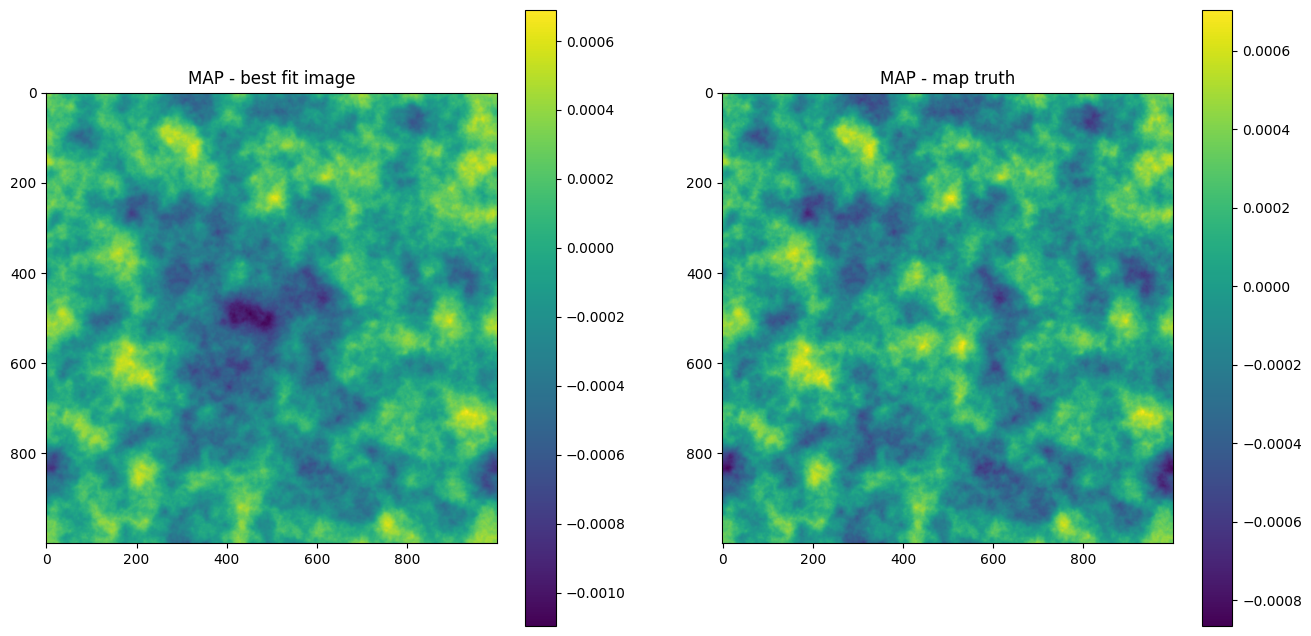

In [16]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
axes[1].title.set_text('MAP - map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

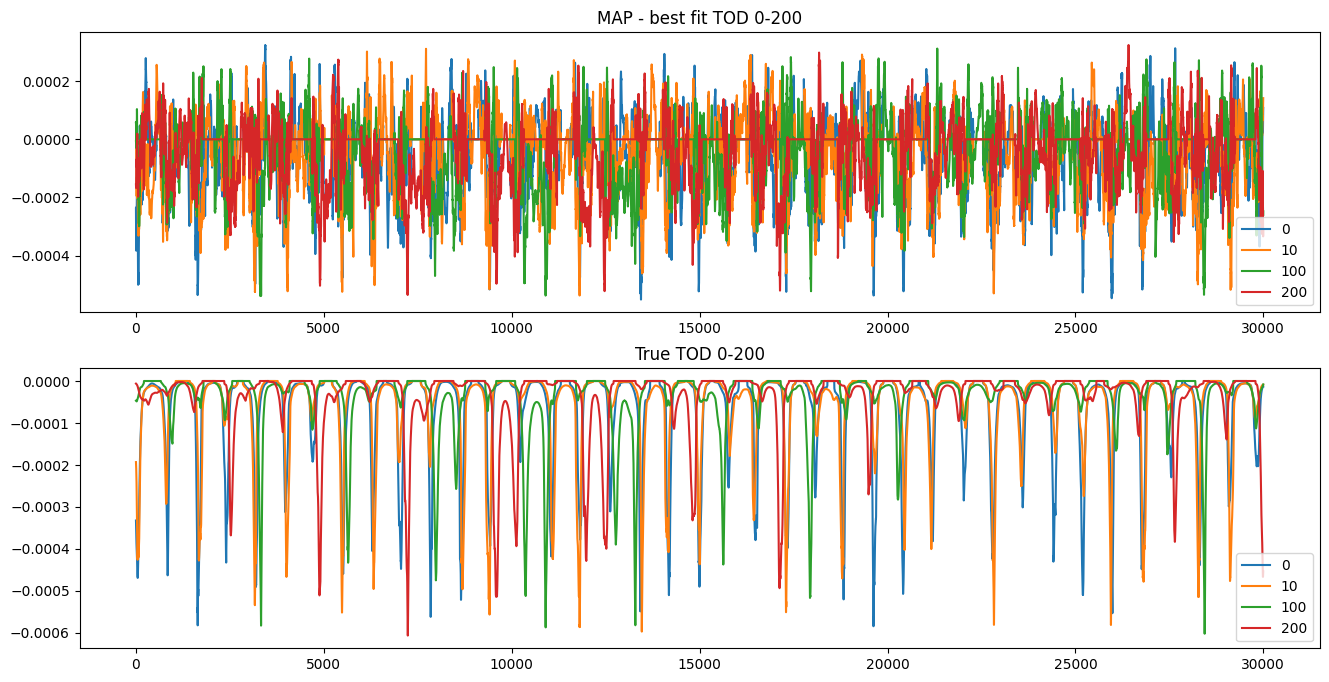

In [17]:
# plot maximum of posterior (mode)
pred_tods = signal_response_tod(samples.pos) # gives time-series

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(pred_tods[i], label=i)
    # im1 = axes[1].plot(tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods[i], label=i)
    
axes[0].title.set_text(f'MAP - best fit TOD 0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True TOD 0-{i}')
axes[1].legend()

plt.show()

In [18]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+7.0980e+06 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:+3.3213e+06 Δ⛰:3.7767e+06 ➽:1.0000e+01
SL: Iteration 2 ⛰:+1.5803e+06 Δ⛰:1.7410e+06 ➽:1.0000e+01
SL: Iteration 3 ⛰:+1.2753e+06 Δ⛰:3.0501e+05 ➽:1.0000e+01
SL: Iteration 4 ⛰:+7.7744e+05 Δ⛰:4.9784e+05 ➽:1.0000e+01
SL: Iteration 5 ⛰:+6.8855e+05 Δ⛰:8.8890e+04 ➽:1.0000e+01
SL: Iteration 6 ⛰:+4.8420e+05 Δ⛰:2.0435e+05 ➽:1.0000e+01
SL: Iteration 7 ⛰:+3.5216e+05 Δ⛰:1.3204e+05 ➽:1.0000e+01
SL: Iteration 8 ⛰:+3.2282e+05 Δ⛰:2.9334e+04 ➽:1.0000e+01
SL: Iteration 9 ⛰:+1.9576e+05 Δ⛰:1.2707e+05 ➽:1.0000e+01
SL: Iteration 10 ⛰:+1.4226e+05 Δ⛰:5.3497e+04 ➽:1.0000e+01
SL: Iteration 11 ⛰:+2.2399e+04 Δ⛰:1.1986e+05 ➽:1.0000e+01
SL: Iteration 12 ⛰:-5.0964e+03 Δ⛰:2.7496e+04 ➽:1.0000e+01
SL: Iteration 13 ⛰:-5.2048e+04 Δ⛰:4.6952e+04 ➽:1.0000e+01
SL: Iteration 14 ⛰:-1.0377e+05 Δ⛰:5.1722e+04 ➽:1.0000e+01
SL: Iteration 15 ⛰:-1.3352e+05 Δ⛰:2.9744e+04 ➽:1.0000e+01
SL: Iteration 16 ⛰:-1.4413e+05 Δ⛰:1.0614e+04 ➽:1.0000e+01
SL: 

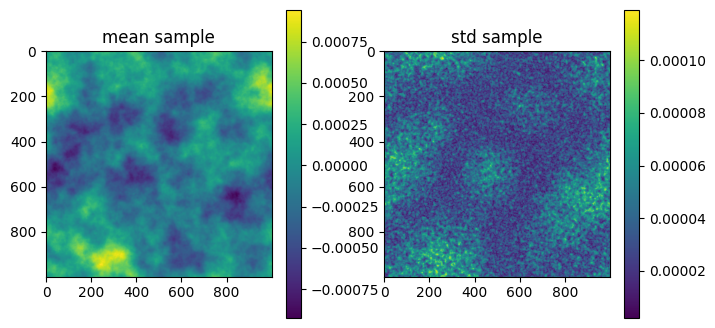

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+4.1167e+06 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:+4.0596e+05 Δ⛰:3.7107e+06 ➽:1.0000e+01
SL: Iteration 2 ⛰:+1.5717e+05 Δ⛰:2.4879e+05 ➽:1.0000e+01
SL: Iteration 3 ⛰:+3.4311e+04 Δ⛰:1.2286e+05 ➽:1.0000e+01
SL: Iteration 4 ⛰:-1.9005e+05 Δ⛰:2.2436e+05 ➽:1.0000e+01
SL: Iteration 5 ⛰:-2.1153e+05 Δ⛰:2.1477e+04 ➽:1.0000e+01
SL: Iteration 6 ⛰:-2.5391e+05 Δ⛰:4.2380e+04 ➽:1.0000e+01
SL: Iteration 7 ⛰:-3.1802e+05 Δ⛰:6.4110e+04 ➽:1.0000e+01
SL: Iteration 8 ⛰:-3.4036e+05 Δ⛰:2.2346e+04 ➽:1.0000e+01
SL: Iteration 9 ⛰:-3.5038e+05 Δ⛰:1.0015e+04 ➽:1.0000e+01
SL: Iteration 10 ⛰:-3.6998e+05 Δ⛰:1.9596e+04 ➽:1.0000e+01
SL: Iteration 11 ⛰:-3.9650e+05 Δ⛰:2.6525e+04 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.0512e+05 Δ⛰:8.6179e+03 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.1835e+05 Δ⛰:1.3231e+04 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.2750e+05 Δ⛰:9.1535e+03 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.3791e+05 Δ⛰:1.0413e+04 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.4216e+05 Δ⛰:4.2501e+03 ➽:1.0000e+01
SL: 

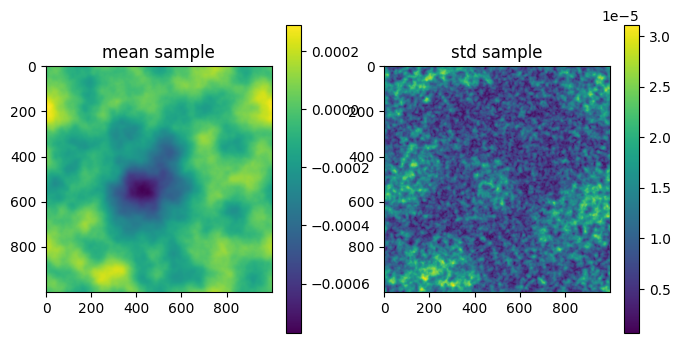

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+2.3443e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-8.3643e+04 Δ⛰:3.1807e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-3.4917e+05 Δ⛰:2.6553e+05 ➽:1.0000e+01
SL: Iteration 3 ⛰:-3.6280e+05 Δ⛰:1.3630e+04 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.2075e+05 Δ⛰:5.7946e+04 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.3328e+05 Δ⛰:1.2535e+04 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.4997e+05 Δ⛰:1.6689e+04 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.5659e+05 Δ⛰:6.6200e+03 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.6054e+05 Δ⛰:3.9520e+03 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.6758e+05 Δ⛰:7.0336e+03 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.7872e+05 Δ⛰:1.1147e+04 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.8027e+05 Δ⛰:1.5419e+03 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.8198e+05 Δ⛰:1.7089e+03 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.8489e+05 Δ⛰:2.9193e+03 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.8850e+05 Δ⛰:3.6037e+03 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9063e+05 Δ⛰:2.1270e+03 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9147e+05 Δ⛰:8.4291e+02 ➽:1.0000e+01
SL: 

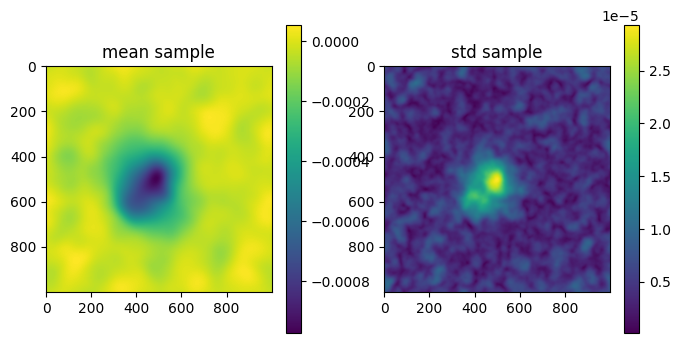

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:-1.8087e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.4922e+05 Δ⛰:2.6834e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.7446e+05 Δ⛰:2.5246e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.7967e+05 Δ⛰:5.2105e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.8557e+05 Δ⛰:5.8988e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9121e+05 Δ⛰:5.6356e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9362e+05 Δ⛰:2.4097e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9384e+05 Δ⛰:2.2084e+02 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9506e+05 Δ⛰:1.2241e+03 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9576e+05 Δ⛰:6.9558e+02 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9629e+05 Δ⛰:5.3828e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9733e+05 Δ⛰:1.0309e+03 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9811e+05 Δ⛰:7.8906e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9859e+05 Δ⛰:4.8051e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9886e+05 Δ⛰:2.6413e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9902e+05 Δ⛰:1.5787e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9913e+05 Δ⛰:1.1377e+02 ➽:1.0000e+01
SL: 

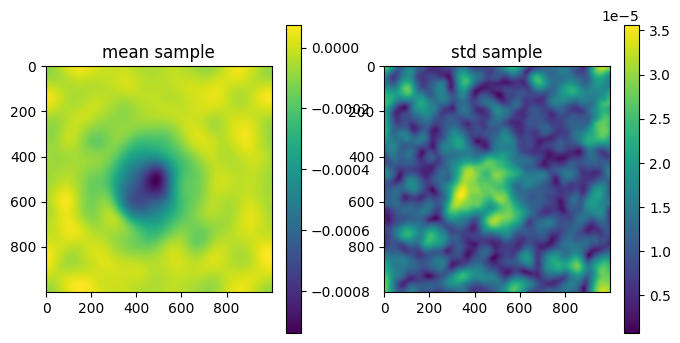

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+2.0901e+06 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-1.8252e+05 Δ⛰:2.2727e+06 ➽:1.0000e+01
SL: Iteration 2 ⛰:-3.0086e+05 Δ⛰:1.1834e+05 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.4621e+05 Δ⛰:1.4534e+05 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.5340e+05 Δ⛰:7.1908e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.6204e+05 Δ⛰:8.6412e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.8341e+05 Δ⛰:2.1375e+04 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.8711e+05 Δ⛰:3.6969e+03 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.8840e+05 Δ⛰:1.2896e+03 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9259e+05 Δ⛰:4.1918e+03 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9298e+05 Δ⛰:3.8843e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9393e+05 Δ⛰:9.5418e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9623e+05 Δ⛰:2.2967e+03 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9741e+05 Δ⛰:1.1785e+03 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9750e+05 Δ⛰:9.3422e+01 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9756e+05 Δ⛰:5.3751e+01 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9756e+05 Δ⛰:4.8788e+00 ➽:1.0000e+01
SL: 

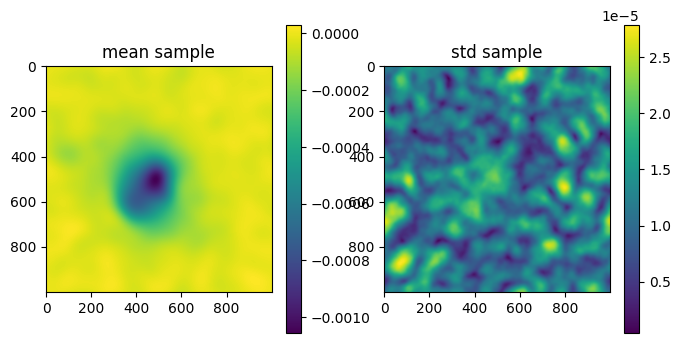

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:+3.5688e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.1500e+05 Δ⛰:7.7188e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.6165e+05 Δ⛰:4.6650e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.6874e+05 Δ⛰:7.0961e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.8467e+05 Δ⛰:1.5931e+04 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.8672e+05 Δ⛰:2.0482e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9193e+05 Δ⛰:5.2062e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9248e+05 Δ⛰:5.5300e+02 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9611e+05 Δ⛰:3.6297e+03 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9673e+05 Δ⛰:6.1976e+02 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9848e+05 Δ⛰:1.7446e+03 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9892e+05 Δ⛰:4.4472e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9908e+05 Δ⛰:1.5640e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9946e+05 Δ⛰:3.8303e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9969e+05 Δ⛰:2.2677e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9978e+05 Δ⛰:9.4291e+01 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9979e+05 Δ⛰:5.1635e+00 ➽:1.0000e+01
SL: 

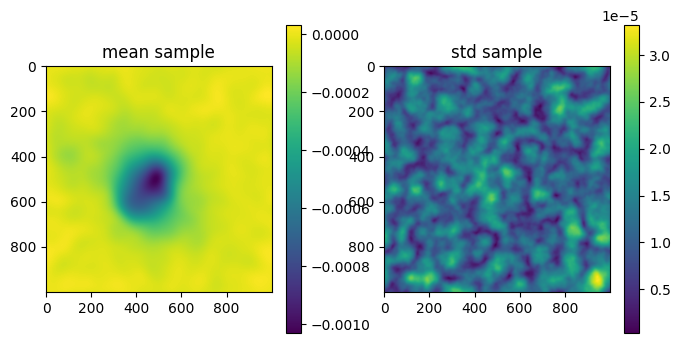

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+4.6352e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.1605e+05 Δ⛰:8.7956e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.7251e+05 Δ⛰:5.6469e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8724e+05 Δ⛰:1.4725e+04 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.9089e+05 Δ⛰:3.6533e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9238e+05 Δ⛰:1.4837e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9487e+05 Δ⛰:2.4948e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9598e+05 Δ⛰:1.1098e+03 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9616e+05 Δ⛰:1.8018e+02 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9712e+05 Δ⛰:9.5947e+02 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9782e+05 Δ⛰:6.9976e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9882e+05 Δ⛰:9.9698e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9902e+05 Δ⛰:2.0607e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9914e+05 Δ⛰:1.1487e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9937e+05 Δ⛰:2.3138e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9958e+05 Δ⛰:2.0604e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9961e+05 Δ⛰:3.4506e+01 ➽:1.0000e+01
SL: 

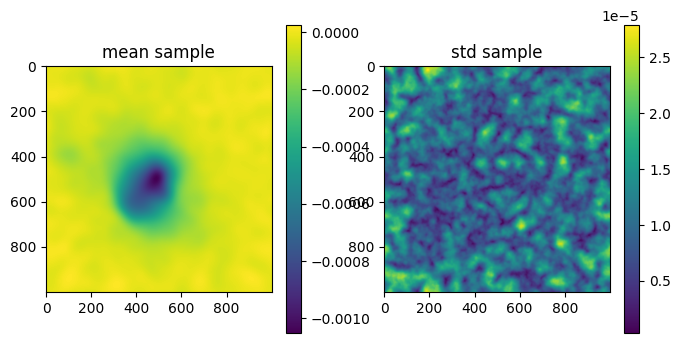

OPTIMIZE_KL: Starting 0008
SL: Iteration 0 ⛰:-3.4228e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.7816e+05 Δ⛰:1.3588e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.8648e+05 Δ⛰:8.3240e+03 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8958e+05 Δ⛰:3.0964e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.9177e+05 Δ⛰:2.1876e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9312e+05 Δ⛰:1.3493e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9506e+05 Δ⛰:1.9484e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9535e+05 Δ⛰:2.8133e+02 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9587e+05 Δ⛰:5.2589e+02 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9710e+05 Δ⛰:1.2337e+03 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9736e+05 Δ⛰:2.5847e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9841e+05 Δ⛰:1.0492e+03 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9860e+05 Δ⛰:1.8244e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9875e+05 Δ⛰:1.5319e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9910e+05 Δ⛰:3.5518e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9936e+05 Δ⛰:2.5683e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9948e+05 Δ⛰:1.2178e+02 ➽:1.0000e+01
SL: 

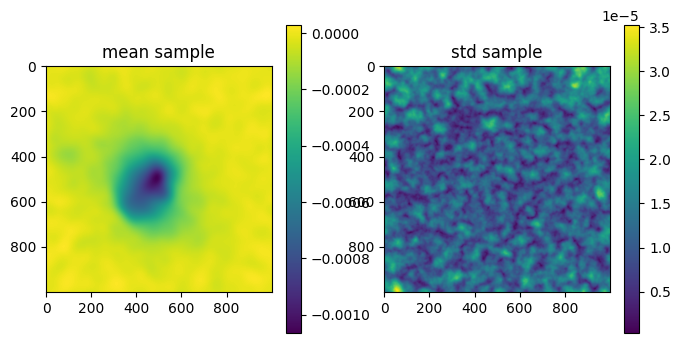

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:-2.7546e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.1932e+05 Δ⛰:1.4386e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.8528e+05 Δ⛰:6.5959e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8700e+05 Δ⛰:1.7191e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.8961e+05 Δ⛰:2.6147e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9043e+05 Δ⛰:8.2274e+02 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9239e+05 Δ⛰:1.9543e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9398e+05 Δ⛰:1.5927e+03 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9413e+05 Δ⛰:1.5432e+02 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9605e+05 Δ⛰:1.9116e+03 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9638e+05 Δ⛰:3.3361e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9695e+05 Δ⛰:5.7089e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9703e+05 Δ⛰:8.2598e+01 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9744e+05 Δ⛰:4.1190e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9791e+05 Δ⛰:4.6677e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9815e+05 Δ⛰:2.3585e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9828e+05 Δ⛰:1.3676e+02 ➽:1.0000e+01
SL: 

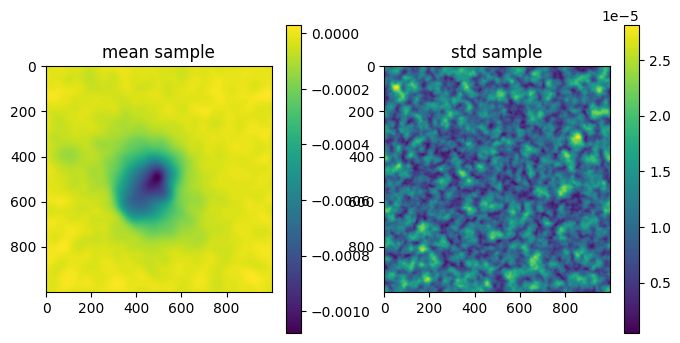

OPTIMIZE_KL: Starting 0010
SL: Iteration 0 ⛰:-3.1717e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.7076e+05 Δ⛰:1.5359e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.8125e+05 Δ⛰:1.0495e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8454e+05 Δ⛰:3.2913e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.9100e+05 Δ⛰:6.4555e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9286e+05 Δ⛰:1.8620e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9396e+05 Δ⛰:1.1007e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9420e+05 Δ⛰:2.4080e+02 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9533e+05 Δ⛰:1.1266e+03 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9574e+05 Δ⛰:4.1233e+02 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9650e+05 Δ⛰:7.6354e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9672e+05 Δ⛰:2.1593e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9706e+05 Δ⛰:3.4378e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9738e+05 Δ⛰:3.1811e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9758e+05 Δ⛰:1.9670e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9784e+05 Δ⛰:2.6074e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9800e+05 Δ⛰:1.6382e+02 ➽:1.0000e+01
SL: 

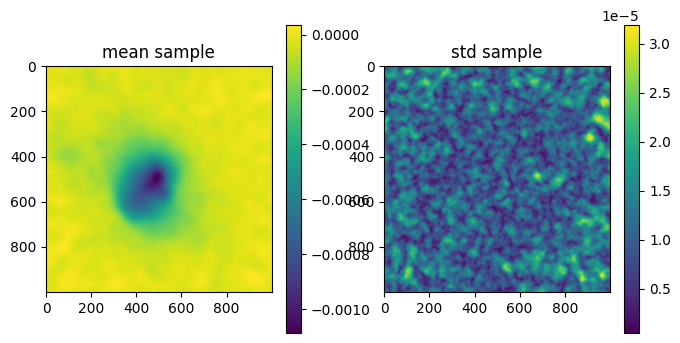

OPTIMIZE_KL: Starting 0011
SL: Iteration 0 ⛰:-2.9268e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.5077e+05 Δ⛰:1.5809e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.7875e+05 Δ⛰:2.7983e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8506e+05 Δ⛰:6.3056e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.8946e+05 Δ⛰:4.3986e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9060e+05 Δ⛰:1.1443e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9193e+05 Δ⛰:1.3323e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9297e+05 Δ⛰:1.0348e+03 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9385e+05 Δ⛰:8.7804e+02 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9452e+05 Δ⛰:6.7309e+02 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9557e+05 Δ⛰:1.0555e+03 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9588e+05 Δ⛰:3.0555e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9618e+05 Δ⛰:2.9932e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9645e+05 Δ⛰:2.7163e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9699e+05 Δ⛰:5.4041e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9721e+05 Δ⛰:2.2160e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9738e+05 Δ⛰:1.6437e+02 ➽:1.0000e+01
SL: 

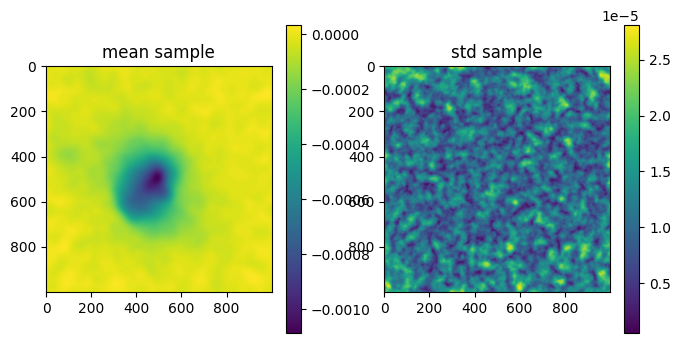

OPTIMIZE_KL: Starting 0012
SL: Iteration 0 ⛰:-2.3944e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.6070e+05 Δ⛰:2.2126e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.7922e+05 Δ⛰:1.8525e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8359e+05 Δ⛰:4.3724e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.8861e+05 Δ⛰:5.0134e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9044e+05 Δ⛰:1.8272e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9417e+05 Δ⛰:3.7335e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9459e+05 Δ⛰:4.2006e+02 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9501e+05 Δ⛰:4.1738e+02 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9619e+05 Δ⛰:1.1861e+03 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9701e+05 Δ⛰:8.2026e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9742e+05 Δ⛰:4.0229e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9782e+05 Δ⛰:4.0883e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9808e+05 Δ⛰:2.5923e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9847e+05 Δ⛰:3.8837e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9885e+05 Δ⛰:3.7996e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9901e+05 Δ⛰:1.5631e+02 ➽:1.0000e+01
SL: 

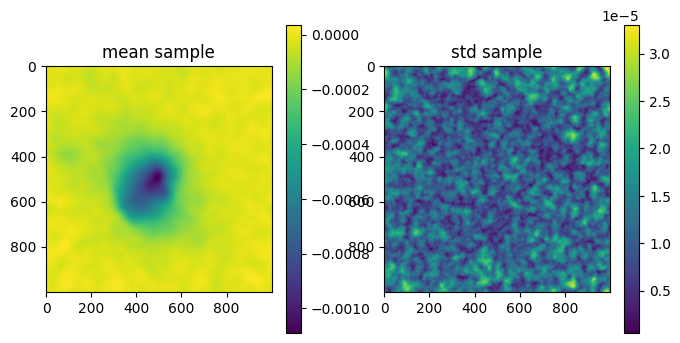

OPTIMIZE_KL: Starting 0013
SL: Iteration 0 ⛰:-3.2831e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.6194e+05 Δ⛰:1.3363e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.7638e+05 Δ⛰:1.4436e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8250e+05 Δ⛰:6.1228e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.9358e+05 Δ⛰:1.1078e+04 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9387e+05 Δ⛰:2.9698e+02 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9460e+05 Δ⛰:7.2313e+02 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9538e+05 Δ⛰:7.8434e+02 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9558e+05 Δ⛰:2.0437e+02 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9613e+05 Δ⛰:5.4923e+02 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9666e+05 Δ⛰:5.2802e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9732e+05 Δ⛰:6.6053e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9762e+05 Δ⛰:2.9513e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9772e+05 Δ⛰:1.0336e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9827e+05 Δ⛰:5.4640e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9849e+05 Δ⛰:2.2499e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9870e+05 Δ⛰:2.0912e+02 ➽:1.0000e+01
SL: 

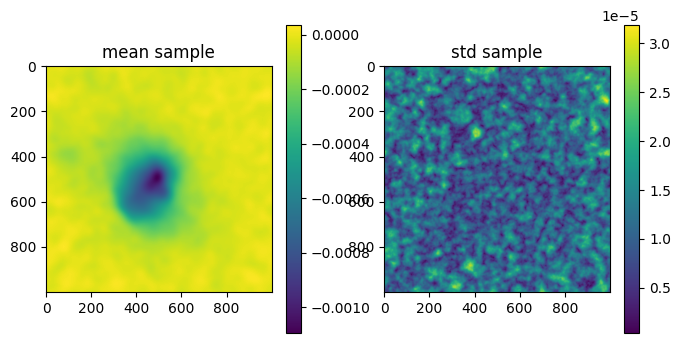

OPTIMIZE_KL: Starting 0014
SL: Iteration 0 ⛰:-2.5383e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.0573e+05 Δ⛰:1.5190e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.7607e+05 Δ⛰:7.0346e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8118e+05 Δ⛰:5.1044e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.8912e+05 Δ⛰:7.9455e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9080e+05 Δ⛰:1.6727e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9225e+05 Δ⛰:1.4543e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9431e+05 Δ⛰:2.0584e+03 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9458e+05 Δ⛰:2.6770e+02 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9535e+05 Δ⛰:7.7337e+02 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9626e+05 Δ⛰:9.1260e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9677e+05 Δ⛰:5.0988e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9730e+05 Δ⛰:5.3076e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9755e+05 Δ⛰:2.5004e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9826e+05 Δ⛰:7.0543e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9852e+05 Δ⛰:2.5984e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9874e+05 Δ⛰:2.2295e+02 ➽:1.0000e+01
SL: 

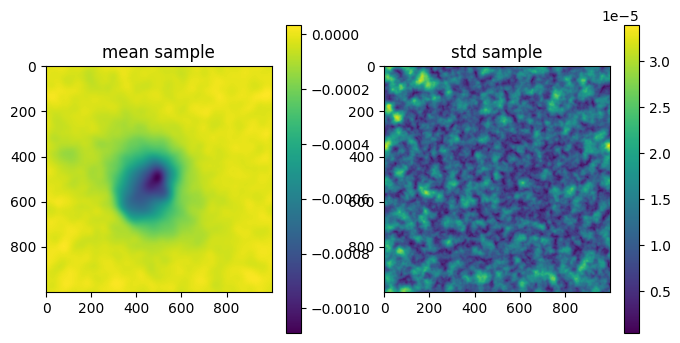

OPTIMIZE_KL: Starting 0015
SL: Iteration 0 ⛰:-2.5145e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.1963e+05 Δ⛰:1.6818e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.7778e+05 Δ⛰:5.8147e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.7988e+05 Δ⛰:2.1035e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.8677e+05 Δ⛰:6.8888e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.8941e+05 Δ⛰:2.6322e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9237e+05 Δ⛰:2.9670e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9329e+05 Δ⛰:9.2233e+02 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9386e+05 Δ⛰:5.6820e+02 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9491e+05 Δ⛰:1.0506e+03 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9548e+05 Δ⛰:5.6522e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9664e+05 Δ⛰:1.1624e+03 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9681e+05 Δ⛰:1.6514e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9733e+05 Δ⛰:5.2064e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9793e+05 Δ⛰:6.0638e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9810e+05 Δ⛰:1.6236e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9832e+05 Δ⛰:2.2146e+02 ➽:1.0000e+01
SL: 

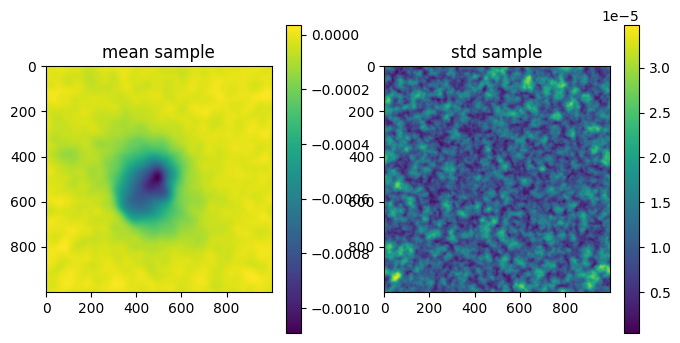

OPTIMIZE_KL: Starting 0016
SL: Iteration 0 ⛰:-3.1019e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.7040e+05 Δ⛰:1.6021e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.7979e+05 Δ⛰:9.3950e+03 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8423e+05 Δ⛰:4.4318e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.9065e+05 Δ⛰:6.4199e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9181e+05 Δ⛰:1.1647e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9373e+05 Δ⛰:1.9246e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9500e+05 Δ⛰:1.2688e+03 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9620e+05 Δ⛰:1.1948e+03 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9638e+05 Δ⛰:1.8519e+02 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9677e+05 Δ⛰:3.8662e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9770e+05 Δ⛰:9.2652e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9802e+05 Δ⛰:3.2189e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9823e+05 Δ⛰:2.1588e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9857e+05 Δ⛰:3.3764e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9870e+05 Δ⛰:1.3156e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9893e+05 Δ⛰:2.2742e+02 ➽:1.0000e+01
SL: 

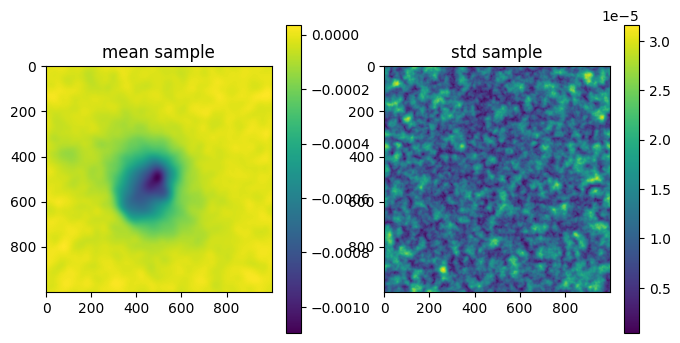

OPTIMIZE_KL: Starting 0017
SL: Iteration 0 ⛰:-3.2617e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.7696e+05 Δ⛰:1.5079e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.8526e+05 Δ⛰:8.3019e+03 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8705e+05 Δ⛰:1.7874e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.9190e+05 Δ⛰:4.8526e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9284e+05 Δ⛰:9.3446e+02 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9426e+05 Δ⛰:1.4255e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9477e+05 Δ⛰:5.0869e+02 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9530e+05 Δ⛰:5.2716e+02 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9644e+05 Δ⛰:1.1436e+03 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9690e+05 Δ⛰:4.5719e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9751e+05 Δ⛰:6.0840e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9790e+05 Δ⛰:3.9742e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9804e+05 Δ⛰:1.3950e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9838e+05 Δ⛰:3.3405e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9855e+05 Δ⛰:1.7743e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9875e+05 Δ⛰:1.9545e+02 ➽:1.0000e+01
SL: 

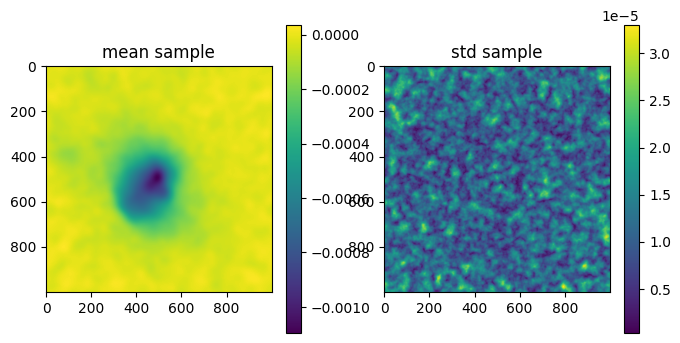

OPTIMIZE_KL: Starting 0018
SL: Iteration 0 ⛰:-3.8384e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.5255e+05 Δ⛰:6.8713e+04 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.7778e+05 Δ⛰:2.5222e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8253e+05 Δ⛰:4.7587e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.8981e+05 Δ⛰:7.2742e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9171e+05 Δ⛰:1.8974e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9300e+05 Δ⛰:1.2904e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9414e+05 Δ⛰:1.1399e+03 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9461e+05 Δ⛰:4.7163e+02 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9527e+05 Δ⛰:6.6489e+02 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9599e+05 Δ⛰:7.1604e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9654e+05 Δ⛰:5.5574e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9686e+05 Δ⛰:3.1966e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9709e+05 Δ⛰:2.2642e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9750e+05 Δ⛰:4.1173e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9777e+05 Δ⛰:2.7218e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9789e+05 Δ⛰:1.1330e+02 ➽:1.0000e+01
SL: 

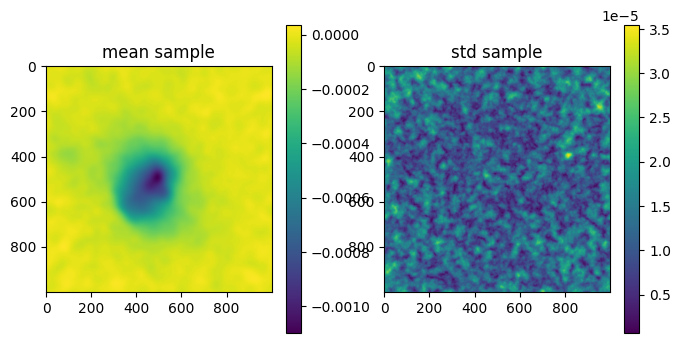

OPTIMIZE_KL: Starting 0019
SL: Iteration 0 ⛰:-2.4917e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.4538e+05 Δ⛰:1.9621e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.7583e+05 Δ⛰:3.0451e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8331e+05 Δ⛰:7.4776e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.8801e+05 Δ⛰:4.7009e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9023e+05 Δ⛰:2.2141e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9226e+05 Δ⛰:2.0329e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9297e+05 Δ⛰:7.1330e+02 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9333e+05 Δ⛰:3.5894e+02 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9527e+05 Δ⛰:1.9427e+03 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9562e+05 Δ⛰:3.4779e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9630e+05 Δ⛰:6.7812e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9685e+05 Δ⛰:5.5514e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9720e+05 Δ⛰:3.4150e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9745e+05 Δ⛰:2.5555e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9768e+05 Δ⛰:2.2856e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9800e+05 Δ⛰:3.1773e+02 ➽:1.0000e+01
SL: 

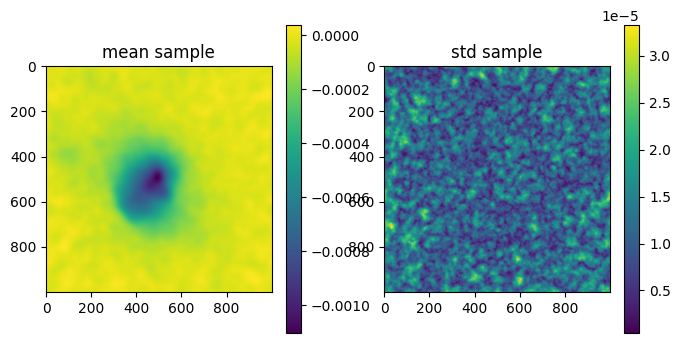

OPTIMIZE_KL: Starting 0020
SL: Iteration 0 ⛰:-3.4589e+05 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:-4.4898e+05 Δ⛰:1.0310e+05 ➽:1.0000e+01
SL: Iteration 2 ⛰:-4.8216e+05 Δ⛰:3.3173e+04 ➽:1.0000e+01
SL: Iteration 3 ⛰:-4.8484e+05 Δ⛰:2.6841e+03 ➽:1.0000e+01
SL: Iteration 4 ⛰:-4.9040e+05 Δ⛰:5.5582e+03 ➽:1.0000e+01
SL: Iteration 5 ⛰:-4.9174e+05 Δ⛰:1.3388e+03 ➽:1.0000e+01
SL: Iteration 6 ⛰:-4.9384e+05 Δ⛰:2.0976e+03 ➽:1.0000e+01
SL: Iteration 7 ⛰:-4.9476e+05 Δ⛰:9.2816e+02 ➽:1.0000e+01
SL: Iteration 8 ⛰:-4.9511e+05 Δ⛰:3.4857e+02 ➽:1.0000e+01
SL: Iteration 9 ⛰:-4.9652e+05 Δ⛰:1.4097e+03 ➽:1.0000e+01
SL: Iteration 10 ⛰:-4.9699e+05 Δ⛰:4.6557e+02 ➽:1.0000e+01
SL: Iteration 11 ⛰:-4.9798e+05 Δ⛰:9.9393e+02 ➽:1.0000e+01
SL: Iteration 12 ⛰:-4.9833e+05 Δ⛰:3.4418e+02 ➽:1.0000e+01
SL: Iteration 13 ⛰:-4.9870e+05 Δ⛰:3.7407e+02 ➽:1.0000e+01
SL: Iteration 14 ⛰:-4.9901e+05 Δ⛰:3.1293e+02 ➽:1.0000e+01
SL: Iteration 15 ⛰:-4.9924e+05 Δ⛰:2.3051e+02 ➽:1.0000e+01
SL: Iteration 16 ⛰:-4.9950e+05 Δ⛰:2.5582e+02 ➽:1.0000e+01
SL: 

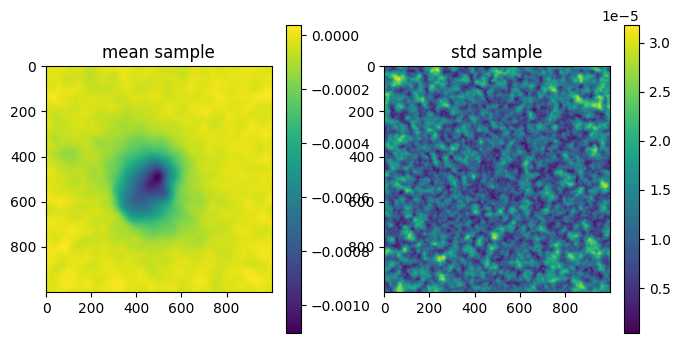

In [19]:
# n_it = 4
n_it = 20
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-12
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(gp_map(s) for s in samples))
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    im0 = axes[0].imshow(mean)
    axes[0].title.set_text('mean sample')
    fig.colorbar(im0)

    im1 = axes[1].imshow(std)
    axes[1].title.set_text('std sample')
    fig.colorbar(im1)
    
    plt.show()

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=20),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    callback=callback,
)

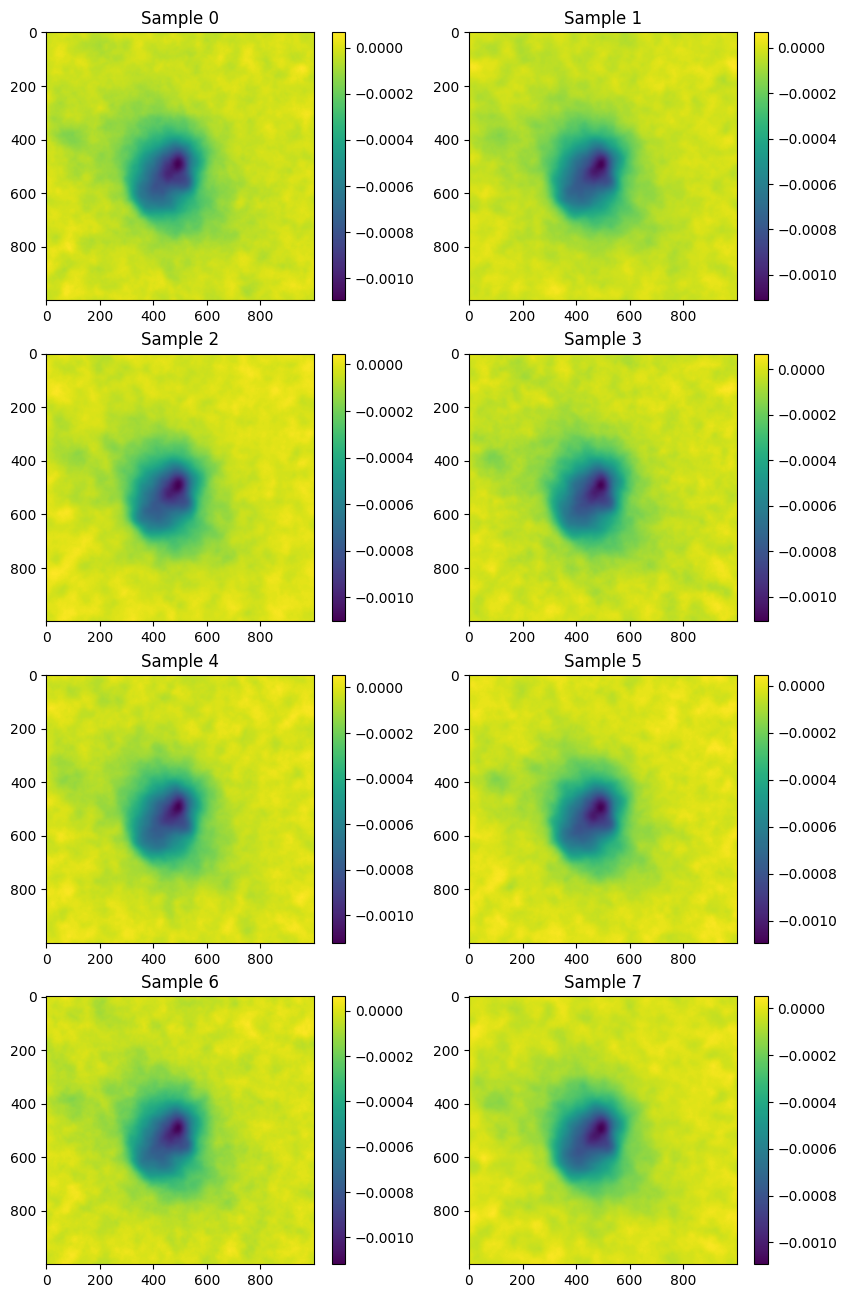

In [20]:
# plot all samples
fig, axes = plt.subplots(4, 2, figsize=(10, 16))

i = 0
for s in samples:
    # print(i//4, i%4)
    # im = axes[i//4][i%4].imshow(signal_response(s))
    im = axes[i//2][i%2].imshow(gp_map(s))
    axes[i//2][i%2].title.set_text(f"Sample {i}")
    fig.colorbar(im)
    
    i += 1

plt.show()

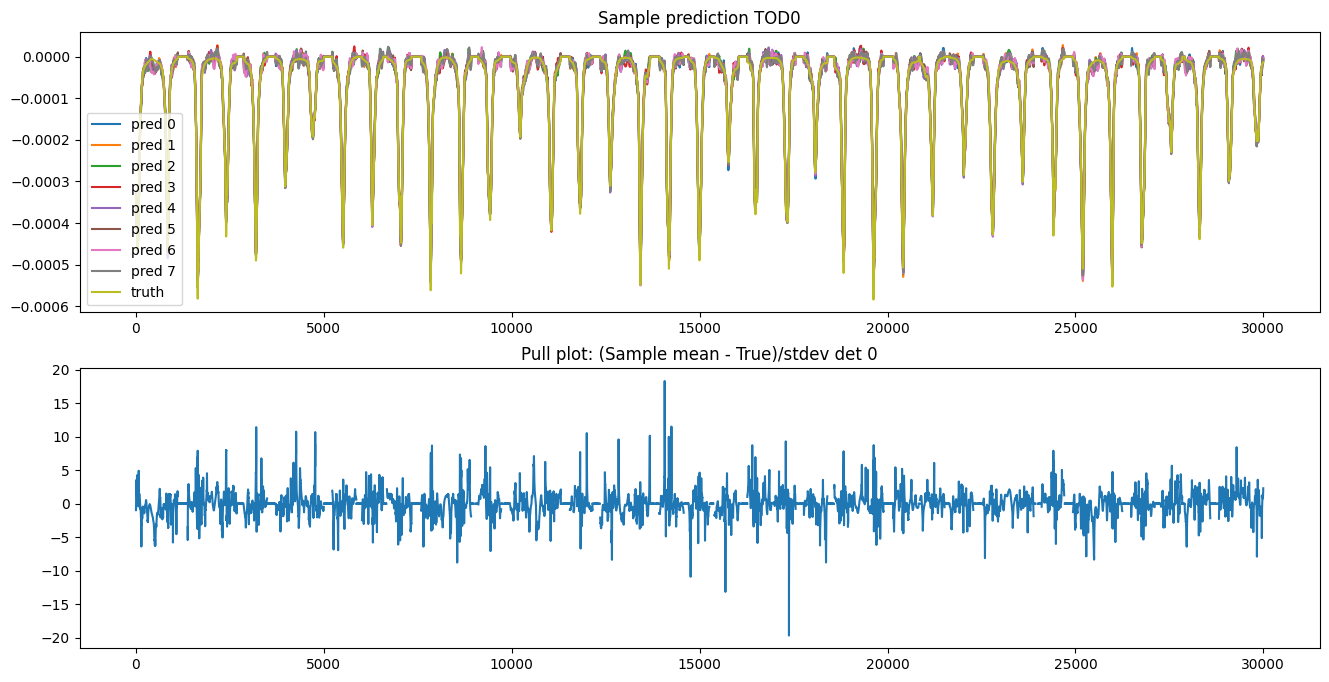

In [21]:
# plot time-series for det 0 for all samples:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

i = 0
for s in samples:

    axes[0].plot(signal_response_tod(s)[0], label=f"pred {i}")
    # axes[1].plot((signal_response_tod(s)[0] - jax_tods[0])/std[0], label=i)
    i += 1

axes[0].plot(jax_tods[0], label="truth")
axes[0].set_title("Sample prediction TOD0")
axes[0].legend()

# axes[1].plot(jax_tods[0])
axes[1].plot((mean[0] - jax_tods[0])/std[0])
axes[1].set_title(f"Pull plot: (Sample mean - True)/stdev det 0")
# axes[1].legend()

plt.show()

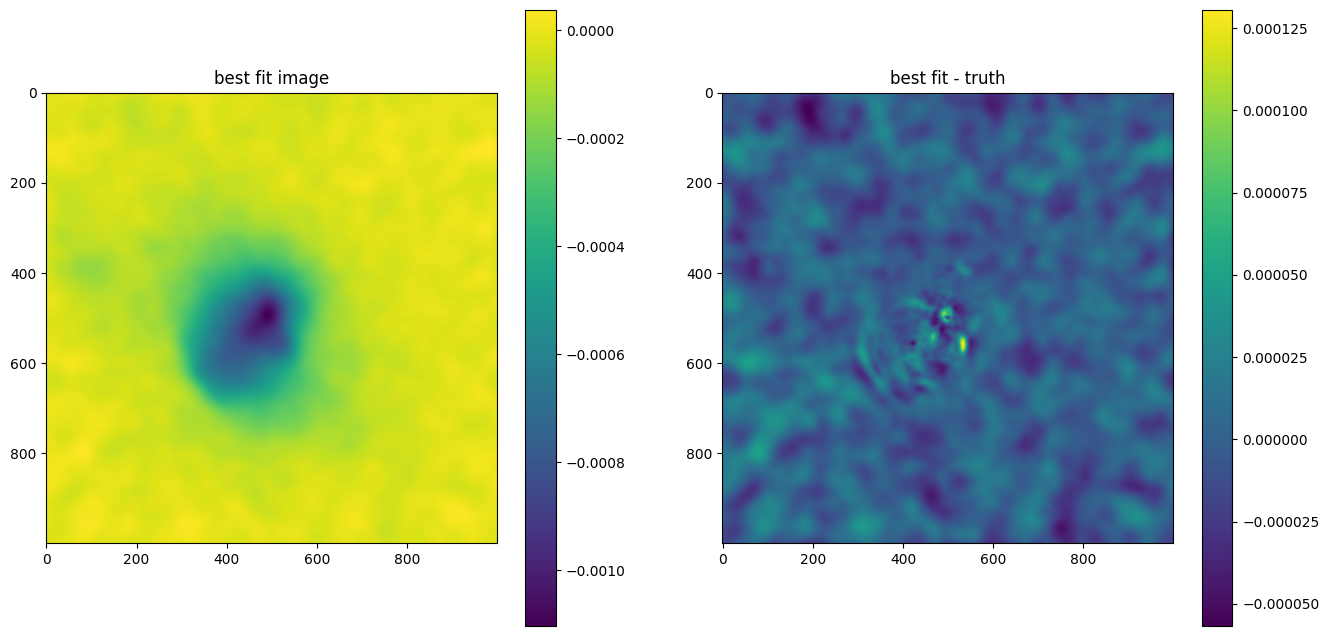

In [22]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map - mapdata_truth[0])
axes[1].title.set_text('best fit - truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

In [23]:
# Compare with maria mapper:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(150, 10),
                   frame="ra_dec",
                   width=0.1,
                   height=0.1,
                   resolution=2e-4,
                   tod_postprocessing={
                        "remove_modes": {"n": 1},
                        # "highpass": {"f": 0.01},
                        "despline": {"spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )

mapper.add_tods(tod_truthmap)
output_map = mapper.run()

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.67s/it]


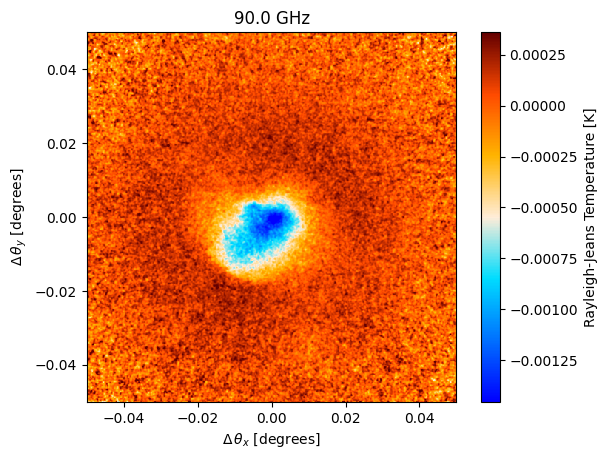

In [33]:
output_map.plot()

In [27]:
mapdata_truth[0].shape

(1000, 1000)

In [28]:
output_map.data[0].shape

(500, 500)

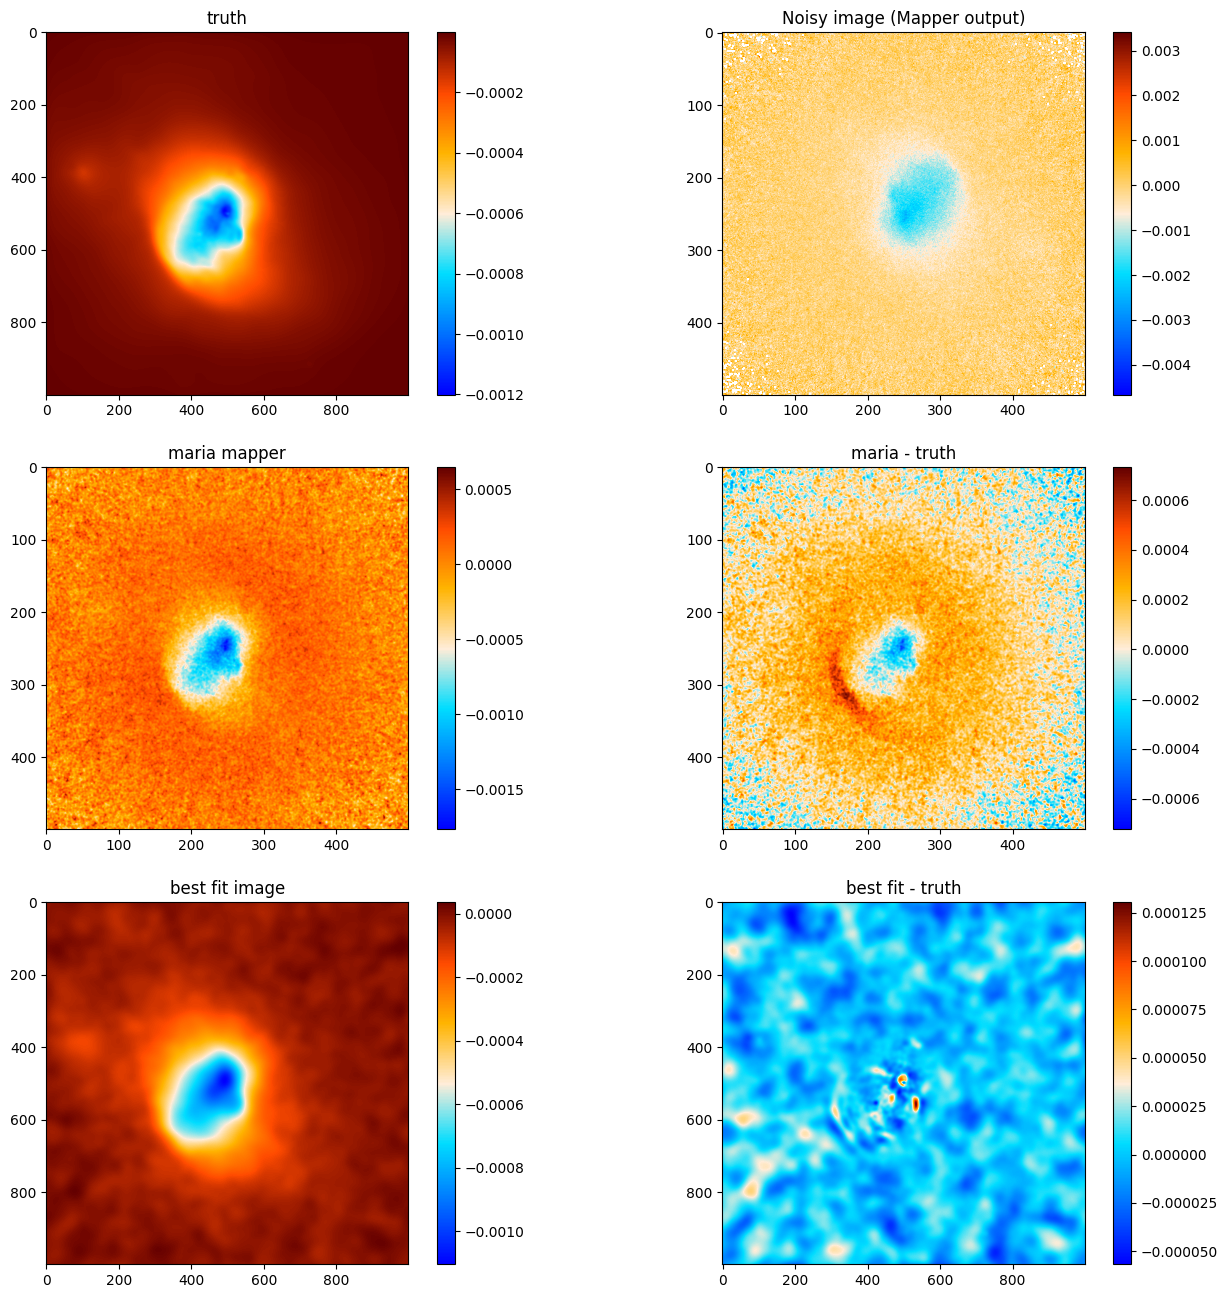

In [35]:
# Compare nifty vs maria
sig_map = gp_map(samples.pos) # when splitting up in different field models
# mincol = -0.0012
# maxcol = 0.
mincol = None
maxcol = None

cmb_cmap = plt.get_cmap('cmb')
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

im0 = axes[0,0].imshow( mapdata_truth[0] , cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[0,0].title.set_text('truth')
fig.colorbar(im0)

im1 = axes[0,1].imshow(output_truthmap.data[0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
fig.colorbar(im1)
axes[0,1].title.set_text("Noisy image (Mapper output)")

im2 = axes[1,0].imshow( np.flip(output_map.data[0], axis=(0,1)), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[1,0].title.set_text('maria mapper')
fig.colorbar(im2)

truth_rescaled = resize(mapdata_truth[0], (500, 500), anti_aliasing=True)
im3 = axes[1,1].imshow(( np.flip(output_map.data[0], axis=(0,1)) - truth_rescaled), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[1,1].title.set_text('maria - truth')
fig.colorbar(im3)

im3 = axes[2,0].imshow(sig_map, cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[2,0].title.set_text('best fit image')
fig.colorbar(im3)

im4 = axes[2,1].imshow((sig_map - mapdata_truth[0]), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[2,1].title.set_text('best fit - truth')
fig.colorbar(im4)

plt.show()